# livedoorニュースコーパスの分類モデル
## (単語トークナイズver)

## Tokenizerの定義

In [1]:
#後で使うTokenizerを定義
import MeCab
def mecab_tokenizer(text):
    tagger = MeCab.Tagger('-Owakati')
    text_list = tagger.parse(text).split(' ')
    del text_list[-1]
    return text_list

#メイン単語だけ抽出する
def mecab_main_tokenizer(text):
    tagger = MeCab.Tagger()
    lists = [] #形態素解析の結果を単語ごとに入れるリスト
    word_list = [] #抽出した単語のみを入れるリスト
    for row in tagger.parse(text).split('\n'):
        lists.append(row.split("\t"))
    del(lists[-1])
    del(lists[-1])
    
    for row in lists:
        if row[1].split(",")[0] == '名詞':
            word_list.append(row[0])
        elif row[1].split(",")[0] in ['動詞','形容詞']:               
            word_list.append(row[1].split(",")[6])
    return word_list

#sentencepieceのバーション
import sentencepiece as spm
s = spm.SentencePieceProcessor()
s.Load("./wiki-ja.model")

def spm_tokenizer(text):
    text = text.lower()
    word_list = s.EncodeAsPieces(text)
    return word_list[1:]


## クラス数を取得 

In [2]:
#category_listを取得
import glob
category_list = glob.glob('./nlp/livedoor-news/*')
filepath = './nlp/livedoor-news/'

for i in range(len(category_list)):
    new_path = category_list[i].replace(filepath,'')
    category_list[i] = new_path
    
category_list = [path for path in category_list if '.txt' not in path]
print(category_list)

[]


In [2]:
category_list = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']

## Fieldを定義→tsvファイルから読み込んで単語ID化→fasttextからembeddingベクトルを取得

In [4]:
import torch
import torchtext

#文のトークンをすべて使うか、メイン単語しか使わないか
def define_text_field(mode,fix_length):
    if mode == 'mecab-all':
        TEXT = torchtext.data.Field(sequential=True,tokenize = mecab_tokenizer,lower=True,fix_length=fix_length,include_lengths=True,batch_first=True)
    elif mode == 'mecab-main':    
        TEXT = torchtext.data.Field(sequential=True,tokenize = mecab_main_tokenizer,lower=True,fix_length=fix_length,include_lengths=True,batch_first=True)
    elif mode == 'spm':
        TEXT = torchtext.data.Field(sequential=True,tokenize = spm_tokenizer,lower=True,fix_length=fix_length,include_lengths=True,batch_first=True)
    return TEXT
        
#Fieldの定義
TEXT = define_text_field('mecab-all',200)        
LABEL = torchtext.data.Field(sequential=False,use_vocab=False)

#前処理(単語ID化)済みのtrain,val,testを作成
train,val,test = torchtext.data.TabularDataset.splits(path='./',train='train_livedoor.tsv',\
                                                      validation='val_livedoor.tsv',test='test_livedoor.tsv',\
                                                      format='tsv',skip_header=True,fields=[('text',TEXT),('label',LABEL)])

#学習済み単語ベクトルを用いてmin_freq回数以上出現した単語に対するベクトルを保持
from torchtext.vocab import FastText
TEXT.build_vocab(train, vectors = FastText(language='ja'),min_freq=2)
print(TEXT.vocab.vectors.shape) #[vocabのサイズ,Embedding次元数]の形になる

torch.Size([39733, 300])


## 使うモデル本体の定義

In [5]:
#モデル本体
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

class livedoor_classify(nn.Module):
    def __init__(self, vocab_size, embed_dim, h_dim, num_class, batch_first=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(TEXT.vocab.vectors) #重み行列の初期値はFasttextの学習済みモデル
        self.lstm = nn.LSTM(embed_dim, h_dim, num_layers=1, batch_first=batch_first)
        self.fc1 = nn.Linear(h_dim, int(h_dim/4))
        self.bn1 = nn.BatchNorm1d(int(h_dim/4))
        self.fc2 = nn.Linear(int(h_dim/4),num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 1
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        
    def forward(self, text):
        embedded = self.embedding(text) #引数は単語IDのテンソルと重み行列
        lstm_output,hidden = self.lstm(embedded)
        x = torch.squeeze(hidden[0])
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return x

## 1エポック当たりの計算をする関数を定義

In [6]:
#訓練とテストで使う関数
from torch.utils.data import DataLoader

def train_func(criterion, train_data, train_iter, optimizer, scheduler):
    train_loss = 0
    train_acc = 0
    for batch in train_iter:
        (text, text_lengths) = batch.text
        label = batch.label
    
        optimizer.zero_grad()
        text, label = Variable(text).to(device), Variable(label).to(device)
        output = model(text)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == label).sum().item()
        
    if scheduler != None:
        scheduler.step()
    
    return train_loss / len(train_data), train_acc / len(train_data)

def val_func(criterion, val_data, val_iter):
    val_loss = 0
    val_acc = 0
    for batch in val_iter:
        (text, text_lengths) = batch.text
        label = batch.label
        text, label = text.to(device), label.to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, label)
            val_loss += loss.item()
            val_acc += (output.argmax(1) == label).sum().item()
            
    return val_loss / len(val_data), val_acc / len(val_data)

## モデルをエポックごとに計算し、結果を表示

In [7]:
#実際にモデルを動かす
import time
import adabound

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#パラメータ設定
vocab_size = TEXT.vocab.vectors.size()[0]
embed_dim = TEXT.vocab.vectors.size()[1]
h_dim = 200 #LSTMの出力次元
num_class = len(category_list) #クラス数
batch_size = 20

#モデル定義
model = livedoor_classify(vocab_size, embed_dim, h_dim ,num_class).to(device)
num_epochs = 50
min_valid_loss = float('inf')

#loss定義
criterion = torch.nn.CrossEntropyLoss().to(device)

#モデルを走らせる関数
def model_run(optim = 'SGD', model = model, criterion = criterion, scheduler = None, num_epochs = num_epochs, train = train, val = val):
     #optimizerの定義
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    elif optim == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif optim == 'Adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

    #scheduler（学習率の調整法）の定義
    if scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.5)
    elif scheduler == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
    elif scheduler == 'CosineAnnelingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, \
                                                               threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    elif scheduler == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=2000, step_size_down=None, \
                                                      mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True,\
                                                      base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []

    all_time = time.time()
    for epoch in range(num_epochs):
        #イテレーター作成（返すのはBatchオブジェクト）
        train_iter, val_iter = torchtext.data.Iterator.splits((train,val), \
                                        batch_sizes=(batch_size,batch_size),device=device,\
                                                                    repeat=False,sort=False)

        start_time = time.time() #1エポックのスタート時間を計測
        train_loss, train_acc = train_func(criterion, train, train_iter, optimizer, scheduler)
        valid_loss, valid_acc = val_func(criterion, val,val_iter)

        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)

        train_acc_list.append(train_acc)
        val_acc_list.append(valid_acc)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

    end_time = time.time()
    print('\n 合計時間 {} 分　{}秒'.format((end_time-all_time) / 60,(end_time-all_time) % 60))
    
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

train_loss_list, val_loss_list, train_acc_list, val_acc_list = model_run(optim = 'Adam')

Epoch: 1  | 所要時間 0 分 3 秒
	Loss: 0.1168(train)	|	Acc: 12.2%(train)
	Loss: 0.1141(valid)	|	Acc: 13.8%(valid)
Epoch: 2  | 所要時間 0 分 3 秒
	Loss: 0.1053(train)	|	Acc: 19.5%(train)
	Loss: 0.1020(valid)	|	Acc: 20.3%(valid)
Epoch: 3  | 所要時間 0 分 3 秒
	Loss: 0.0922(train)	|	Acc: 29.3%(train)
	Loss: 0.0921(valid)	|	Acc: 28.4%(valid)
Epoch: 4  | 所要時間 0 分 3 秒
	Loss: 0.0755(train)	|	Acc: 45.3%(train)
	Loss: 0.0818(valid)	|	Acc: 40.2%(valid)
Epoch: 5  | 所要時間 0 分 3 秒
	Loss: 0.0614(train)	|	Acc: 58.6%(train)
	Loss: 0.0813(valid)	|	Acc: 43.6%(valid)
Epoch: 6  | 所要時間 0 分 3 秒
	Loss: 0.0500(train)	|	Acc: 66.8%(train)
	Loss: 0.0793(valid)	|	Acc: 47.6%(valid)
Epoch: 7  | 所要時間 0 分 3 秒
	Loss: 0.0414(train)	|	Acc: 73.4%(train)
	Loss: 0.0835(valid)	|	Acc: 47.8%(valid)
Epoch: 8  | 所要時間 0 分 3 秒
	Loss: 0.0361(train)	|	Acc: 77.4%(train)
	Loss: 0.0833(valid)	|	Acc: 47.9%(valid)
Epoch: 9  | 所要時間 0 分 3 秒
	Loss: 0.0328(train)	|	Acc: 80.1%(train)
	Loss: 0.0911(valid)	|	Acc: 47.5%(valid)
Epoch: 10  | 所要時間 0 分 3 秒
	Loss: 0.02

## グラフにlossとaccを描画

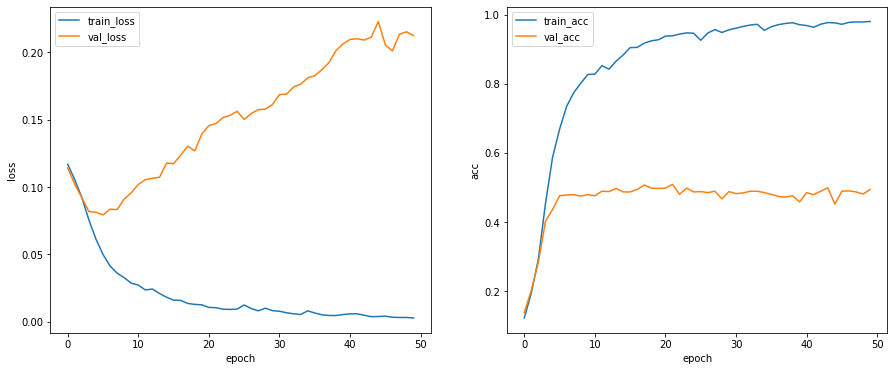

In [9]:
import matplotlib.pyplot as plt

fig,(loss, acc) = plt.subplots(ncols = 2, figsize=(15,6), sharex = True)

loss.plot(range(num_epochs),train_loss_list,label='train_loss')
loss.plot(range(num_epochs),val_loss_list,label='val_loss')
acc.plot(range(num_epochs),train_acc_list,label='train_acc')
acc.plot(range(num_epochs),val_acc_list,label='val_acc')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

acc.set_xlabel('epoch')
acc.set_ylabel('acc')

loss.legend()
acc.legend()

fig.show()

In [10]:
#テストデータで評価
train_iter, val_iter, test_iter = torchtext.data.Iterator.splits((train,val,test), \
                                        batch_sizes=(batch_size,batch_size,batch_size),device=device,\
                                                                    repeat=False,sort=False)

def test_func(criterion, test_data, test_iter):
    loss = 0
    acc = 0
    for batch in test_iter:
        (text, text_lengths) = batch.text
        label = batch.label
        text, label = text.to(device), label.to(device)
        with torch.no_grad():
            output = model(text)
            loss = criterion(output, label)
            loss += loss.item()
            acc += (output.argmax(1) == label).sum().item()
            
    return loss / len(test_data), acc / len(test_data)

print('Checking the results of test dataset...')
test_loss, test_acc = test_func(criterion, test, test_iter)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0080(test)	|	Acc: 46.4%(test)
